<h2>导入库</h2>

In [1]:
import numpy as np
import paddle
import paddle.fluid as fluid
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

<h2>数据预处理</h2>

性别
长度
直径
高度
总重量
皮重
内脏重量
壳重

年龄

In [2]:
#读取数据
colnames = ['sex']+['length']+['diameter']+['height']+['allweight']+['skin']+['iweght']+['shell']+['age']
print_data = pd.read_csv('/home/aistudio/data/data1343/data.txt',names = colnames) #dataframe
print_data.head()

,sex,length,diameter,height,allweight,skin,iweght,shell,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
it=print_data['age'].unique()

In [4]:
#查看数据信息
#print_data.info()

In [5]:
df=print_data['sex']
# df=df.replace('M',001).replace('F',010).replace('I',100)  ###设为0，是否相当于抵消了该特征的影响？？
df=df.replace('M',4).replace('F',2).replace('I',1)
print_data['sex']=df

In [6]:
#转化为矩阵格式，方便后续处理
global train_data,test_data
data=print_data.values  #矩阵格式

# ratio = 0.8 #分割的训练集部分
# offset = int(data.shape[0]*ratio)
# test_data2 = data[offset:].copy()
'''
上面三行目的是创建出一个测试集标签不变的数组
'''

#取得每一列的最大值最小值平均值
maximums,minimums,avgs = data.max(axis=0),data.min(axis=0),data.sum(axis=0)/data.shape[0]

#归一化
feature_num = 9
# for i in range(1,feature_num-1):
for i in range(1,feature_num-1):
    #data[:,i] = #####
    data[:,i] = (data[:,i]-avgs[i])/(maximums[i]-minimums[i])
### END CODE HERE ###

# print 'normalization:',data[:,1].max(axis = 0) 检验效果

In [7]:
# data

<h3>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;数据集分割</h3>

In [8]:
ratio = 0.8 #分割的训练集部分
offset = int(data.shape[0]*ratio)

train_data = data[:offset].copy()

test_data = data[offset:].copy()
print(len(data))
print(len(train_data))

4177
3341


<h2>定义reader</h2>

In [9]:
def read_data(data_set):
    def reader():    
        for dataa in data_set:
            yield dataa[:-1],dataa[-1:]
    return reader

In [10]:
def train():
    global train_data
    return read_data(train_data)

def test():
    global test_data
    return read_data(test_data)
#测试正确

<h2>训练过程</h2>

In [11]:
#定义运算场所
#使用CPU训练
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

In [12]:
def train_program():

    x = fluid.layers.data(name="x",shape=[8],dtype="float32")
    
    ####   改进的话，y的类型要变为int64
    
    ### y = fluid.layers.data(name="y",shape=[1],dtype="float32") 
    y=fluid.layers.data(name="y",shape=[1],dtype='float32')
    
    h1=fluid.layers.fc(input=x,size=16,act=None)
    h2=fluid.layers.fc(input=h1,size=16,act="relu")
    h3=fluid.layers.fc(input=h2,size=8,act="relu")
    ###增加网络层数，则下面也需要变化
    
    y_predict = fluid.layers.fc(input=h3,size=1,act=None)
    #size表示输出结果的个数，回归问题一般只有一个结果
    loss = fluid.layers.square_error_cost(input=y_predict,label=y)
    avg_loss = fluid.layers.mean(loss)
    
    return avg_loss

In [13]:
# 创建optimizer，更多优化算子可以参考 fluid.optimizer()
def optimizer_program():
    
    lr=0.001
    sgd_optimizer=fluid.optimizer.SGD(learning_rate=lr)
#     mom_optimizer=fluid.optimizer.Momentum(learning_rate=lr)
    return sgd_optimizer

    #minixise已经被集成了

In [14]:
# 数据层和数组索引映射，用于trainer训练时喂数据
feed_order=['x', 'y']
# 保存模型
params_dirname = "easy_fit_a_line.inference.model"

# Plot data
from paddle.v2.plot import Ploter
train_title = "Train cost"
test_title = "Test cost"
plot_cost = Ploter(train_title, test_title)

step = 0

# 事件处理
def event_handler_plot(event):
    global step
    if isinstance(event, fluid.EndStepEvent):
        if event.step % 10 == 0:
            plot_cost.append(train_title, step, event.metrics[0])
            plot_cost.plot()
        if event.step % 100 == 0: # 每10个batch,记录cost
            test_metrics = trainer.test(
            reader=test_reader, feed_order=feed_order)

            plot_cost.append(test_title, step, test_metrics[0])
            plot_cost.plot()

#             if test_metrics[0] < 1.0:
#                 # 如果准确率达到阈值，则停止训练
#                 print('loss is less than 0.00001, stop')
#                 trainer.stop()

        # 将参数存储，用于预测使用
        if params_dirname is not None:
            trainer.save_params(params_dirname)

    step += 1

In [15]:
BATCH_SIZE = 256  #

# 设置训练reader
train_reader = paddle.batch(
paddle.reader.shuffle(
    train(), buf_size=5000),
    batch_size=BATCH_SIZE)

#设置测试reader
test_reader = paddle.batch(
paddle.reader.shuffle(
    test(), buf_size=5000),
batch_size=BATCH_SIZE)

In [16]:
trainer = fluid.Trainer(
    train_func=train_program,
    place=place,
    optimizer_func=optimizer_program)

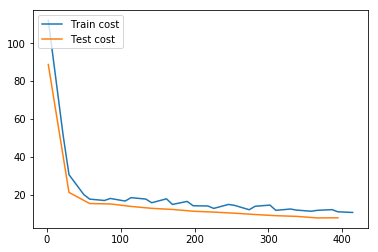

<Figure size 432x288 with 0 Axes>

In [17]:
trainer.train(
    reader=train_reader,  #数据
    num_epochs=15,   #迭代次数
    event_handler=event_handler_plot,
    feed_order=feed_order)  #喂的格式

<h2>预测</h2>

In [18]:
def inference_program():
    x = fluid.layers.data(name='x', shape=[8], dtype='float32')
    h1=fluid.layers.fc(input=x,size=16,act=None)
    h2=fluid.layers.fc(input=h1,size=16,act="relu")
    h3=fluid.layers.fc(input=h2,size=8,act="relu")
    y_predict = fluid.layers.fc(input=h3, size=1, act=None)
    return y_predict

In [19]:
inferencer = fluid.Inferencer(
infer_func=inference_program, param_path=params_dirname, place=place)

# BATCH_SIZE = 10
# test_readerr = paddle.batch(
#     read_data(test_data), batch_size=BATCH_SIZE
# )

# 取出一个 mini-batch
for mini_batch in test_reader(): 
    # 转化为 numpy 的 ndarray 结构，并且设置数据类型
    test_x = np.array([data[:-1] for data in mini_batch]).astype("float32")
    test_y = np.array([data[-1] for data in mini_batch]).astype("float32")
    # 真实进行预测
    mini_batch_result = inferencer.infer({'x': test_x})
    tmp=len(mini_batch_result[0])
#     print(tmp)
#     print('true预测结果：%s'%mini_batch_result)
    for i in xrange(tmp):
        mini_batch_result[0][i]=round(mini_batch_result[0][i])
#         mini_batch_result[0][i]=round((mini_batch_result[0][i])*((maximums[feature_num-1]-minimums[feature_num-1]))+avgs[feature_num-1])
#         print((mini_batch_result[0][0]))
#     print('预测结果：%s'%mini_batch_result)
    
    # 打印真实结果    
#     label = np.array(test_y*((maximums[feature_num-1]-minimums[feature_num-1]))+avgs[feature_num-1]) # 转化为 label
    label = np.array(test_y)
#     print('真实结果：%s'%label)
    break    

In [20]:
def right_ratio(right_counter, total):
    ratio = float(right_counter)/total
    return ratio

In [21]:
aa=0

In [22]:
# 评估函数 data_set 是一个reader
def evl(data_set):
    total = 0    #操作的元素的总数
    right_counter = 0  #正确的元素

    pass_num = 0
#     print(liruoyi)
    for mini_batch in data_set():
        pass_num += 1
        #预测
        test_x = np.array([data[:-1] for data in mini_batch]).astype("float32")
        test_y = np.array([data[-1] for data in mini_batch]).astype("float32")
        
        mini_batch_result = inferencer.infer({'x': test_x})
        tmp=len(mini_batch_result[0])
        for i in xrange(tmp):
            mini_batch_result[0][i]=round(mini_batch_result[0][i])
#             mini_batch_result[0][i]=round((mini_batch_result[0][i])*((maximums[feature_num-1]-minimums[feature_num-1]))+avgs[feature_num-1])
        
#         label = np.array(test_y*((maximums[feature_num-1]-minimums[feature_num-1]))+avgs[feature_num-1]) # 转化为 label
        label = np.array(test_y)
        #计数
        label_len = len(label)
        total += label_len
        for i in xrange(label_len):
#             global aa
#             aa += 1
            if mini_batch_result[0][i] == label[i]:
                right_counter += 1
#     print(right_counter)
#     print(total)
    ratio = right_ratio(right_counter, total)
    return ratio

In [23]:
ratio = evl(train_reader)
print('训练数据的正确率 %0.2f%%'%(ratio*100))

ratio = evl(test_reader)
print('预测数据的正确率 %0.2f%%'%(ratio*100))

训练数据的正确率 16.80%
预测数据的正确率 18.62%


lr=0.001 bound=10 net=1 epoch=5 bs=20 trainright=0.15 testright=0.19<br/>
0.001 10 1 5 32 0.0622 0.0769  <br/>
0.001 10 1 50 32 0.1547 0.1575<br/>
0.001 5 1 50 32 0.1436 0.1442 而且测试曲线后面趋于平缓不动<br/>
0.001 5 1 25 64 0.1866 0.1947 <br/>
0.001 5 2 15 64 0.1647 0.1623<br/>
0.001 5 2 15 64 0.159 0.1875<br/>
0.001 5 3 15 256 0.1659 0.1784 趋于平缓<br/>
0.001 1 3 15 256 0.1704 0.2083<br/>
0.001 1 4 15 256 0.1581 0.1784<br/>

batch_size怎么选，选多大比较合适<br/>
每一层几个神经元